<a href="https://colab.research.google.com/github/DaryaTereshchenko/HateSpeechDetection/blob/main/HateBert_SM_all_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sentence_transformers
!pip install transformers

In [22]:
!pip install ktrain==0.33.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 48.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 59.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.0/266.0 KB 28.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 KB 41.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.33.0-py3-none-any.whl size=25313831 sha256=657628055dd3485c379dbff0904ea8c3ee34198a33c50189dc35d377a0da1f5d
  Stored in d

In [2]:
import numpy as np
import pandas as pd

In [23]:
import ktrain

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
import tensorflow as tf
from sentence_transformers import SentenceTransformer
from transformers import RobertaTokenizer

In [5]:
from transformers import RobertaTokenizer, RobertaConfig, TFRobertaModel

In [6]:
ethos_hate = pd.read_csv("ethos_hate.csv", sep=",", encoding="unicode_escape").drop(columns="label")
ethos_hate["label"] = 1

ethos_neutral = pd.read_csv("ethos_neutral.csv", sep=",", encoding="unicode_escape").drop(columns="label")
ethos_neutral["label"] = 0

train_n = ethos_neutral.sample(frac=0.9, random_state=0)
test_n = ethos_neutral.drop(train_n.index)

train_hate = ethos_hate.sample(frac=0.9, random_state=0)
test_hate = ethos_hate.drop(train_hate.index)


train = pd.concat([train_n, train_hate]).sample(frac=1, random_state=300).reset_index(drop=True)
test = pd.concat([test_n, test_hate]).sample(frac=1, random_state=300).reset_index(drop=True)

print(train.text[0])


What episode number was this?


In [ ]:
train.shape

(898, 2)

In [7]:
hate_speech = pd.read_csv('ethos_sm_hate.csv', sep=";", decimal=",", skiprows=[1,2,3,4], low_memory=False, on_bad_lines='skip').sort_values(by=["CODE"])
neutral_speech = pd.read_csv('ethos_sm_neutral.csv', sep=";", decimal=",", skiprows=[1,2,3,4], low_memory=False, on_bad_lines='skip').sort_values(by=["CODE"])

hate_speech = hate_speech.drop(columns="CODE")
neutral_speech = neutral_speech.drop(columns="CODE")

In [8]:
train_sm_n = neutral_speech.sample(frac=0.9, random_state=0)
test_sm_n = neutral_speech.drop(train_sm_n.index)

train_sm_hate = hate_speech.sample(frac=0.9, random_state=0)
test_sm_hate = hate_speech.drop(train_sm_hate.index)

TrainSM = pd.concat([train_sm_n, train_sm_hate]).sample(frac=1, random_state=300).reset_index(drop=True)
TestSM = pd.concat([test_sm_n, test_sm_hate]).sample(frac=1, random_state=300).reset_index(drop=True)

In [ ]:
trans = TrainSM.T.values

In [ ]:
TestSM.T.shape

(157, 100)

In [ ]:
print("Longest sentence?")
print(max(len(x) for x in train.text.values))
print("Average length?")
print(sum(len(x) for x in train.text.values) / len(train.text.values))


Longest sentence?
3009
Average length?
111.76948775055679


In [9]:
def clean_text(line):
  processed_line = line.lower()
  words = [word for word in word_tokenize(processed_line)]
  processed_line = [word for word in words if word not in set(string.punctuation)]
  text = " ".join(processed_line)
  return text

In [10]:
# Sentences for embeddings
train_sentence_list = list(map(clean_text, train.text.values))
test_sentence_list = list(map(clean_text, test.text.values))

In [ ]:
train_sentence_list

In [11]:
from transformers import AutoTokenizer, TFAutoModel

In [12]:
MODEL_NAME = 'GroNLP/hateBERT'
MAX_LEN = 157

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [13]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification


    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [14]:
train_dict = roberta_encode(train_sentence_list, tokenizer)
train_dict["np_sm"] = np.asarray(TrainSM.values, dtype="float32")

Token indices sequence length is longer than the specified maximum sequence length for this model (776 > 512). Running this sequence through the model will result in indexing errors


In [15]:
test_dict = roberta_encode(test_sentence_list, tokenizer)
test_dict["np_sm"] = np.asarray(TestSM.values,  dtype="float32")

In [16]:

X_train = train_dict
X_test = test_dict

y_train = np.asarray(train.label, dtype='int32').reshape(-1,1)
y_test = np.asarray(test.label, dtype='int32').reshape(-1,1)

In [17]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(
    learning_rate=5e-05, # HF recommendation
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0
)

In [26]:
"""
========================================
HATEBERT + SM
========================================
"""
def build_model1():
  input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
  input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
  input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')
  np_sm = tf.keras.Input(shape=(157,), dtype=tf.float32, name='np_sm')


  # Import RoBERTa model from HuggingFace
  roberta_model = TFAutoModel.from_pretrained("GroNLP/hateBERT", from_pt=True)
  x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

  x = x[0]
  z = np_sm

  x = tf.keras.layers.Dropout(0.1)(x)

  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dropout(0.1)(x)
  x = tf.keras.layers.concatenate([x,z])
  x = tf.keras.layers.Dense(16, activation='relu')(x)
  y = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids, np_sm], outputs=y)

  model.compile(
      optimizer=optimizer,
      loss= tf.keras.losses.binary_crossentropy,
      metrics=['accuracy'])

  return model

In [55]:
"""
========================================
HATEBERT + CNN + SM
========================================
"""
def build_model2(conv_size=128, max_features = 50000, embed_size=128):
  input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
  input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
  input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')
  np_sm = tf.keras.Input(shape=(157,), dtype=tf.float32, name='np_sm')

  # Import RoBERTa model from HuggingFace
  roberta_model = TFAutoModel.from_pretrained("GroNLP/hateBERT", from_pt=True)
  mod = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

  # Huggingface transformers have multiple outputs, embeddings are the first one,
  # so let's slice out the first position
  bert = mod[0]
  z = np_sm

  x1 =  tf.keras.layers.SpatialDropout1D(rate=0.1)(bert)
  x = tf.keras.layers.Conv1D(conv_size, 2, activation='relu', padding='same')(x1)
  x = tf.keras.layers.MaxPooling1D(5, padding='same')(x)
  x = tf.keras.layers.Conv1D(conv_size, 3, activation='relu', padding='same')(x)
  x = tf.keras.layers.MaxPooling1D(5, padding='same')(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.concatenate([x,z])
  x = tf.keras.layers.Dense(16, activation='relu')(x)
  # x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids, np_sm], outputs=x)
  model.compile(
      optimizer=optimizer,
      loss= tf.keras.losses.binary_crossentropy,
      metrics=['accuracy'])

  return model

In [35]:
"""
========================================
HATEBERT + CNN + LSTM + SM
========================================
"""

def build_model3(conv_size=128):
  input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
  input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
  input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')
  np_sm = tf.keras.Input(shape=(157,), dtype=tf.float32, name='np_sm')

  # Import RoBERTa model from HuggingFace
  roberta_model = TFAutoModel.from_pretrained("GroNLP/hateBERT", from_pt=True)
  mod = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

  # Huggingface transformers have multiple outputs, embeddings are the first one,
  # so let's slice out the first position
  bert = mod[0]
  n = np_sm

  x =  tf.keras.layers.SpatialDropout1D(rate=0.0)(bert)
  x0 = tf.keras.layers.Conv1D(128, 10, activation='relu')(x)
  x1 = tf.keras.layers.Conv1D(64, 5, activation='relu')(x0)
  x2 = tf.keras.layers.Conv1D(32, 4, activation='relu')(x1)
  x3 = tf.keras.layers.Conv1D(16, 3, activation='relu')(x2)
  x4 = tf.keras.layers.Conv1D(8, 5, activation='relu')(x3)
  x = tf.keras.layers.MaxPooling1D(pool_size=3)(x4)
  x = tf.keras.layers.Dropout(rate=0.5)(x)
  x = tf.keras.layers.LSTM(100)(x)

  p = tf.keras.layers.MaxPooling1D(pool_size=10)(x0)
  p = tf.keras.layers.Dropout(rate=0.5)(p)
  p = tf.keras.layers.LSTM(100)(p)

  o = tf.keras.layers.MaxPooling1D(pool_size=8)(x1)
  o = tf.keras.layers.Dropout(rate=0.5)(o)
  o = tf.keras.layers.LSTM(100)(o)

  i = tf.keras.layers.MaxPooling1D(pool_size=6)(x2)
  i = tf.keras.layers.Dropout(rate=0.5)(i)
  i = tf.keras.layers.LSTM(100)(i)

  r = tf.keras.layers.MaxPooling1D(pool_size=4)(x3)
  r = tf.keras.layers.Dropout(rate=0.5)(r)
  r = tf.keras.layers.LSTM(100)(r)

  t = tf.keras.layers.MaxPooling1D(pool_size=3)(x4)
  t = tf.keras.layers.Dropout(rate=0.5)(t)
  t = tf.keras.layers.LSTM(100)(t)

  y = tf.keras.layers.LSTM(500)(bert)
  y = tf.keras.layers.Dense(250, activation='relu')(y)
  y = tf.keras.layers.Dropout(rate=0.5)(y)

  z = tf.keras.layers.concatenate([x, p, o, i, r, t, y, n])

  z = tf.keras.layers.Dense(400, activation='relu')(z)
  z = tf.keras.layers.Dropout(0.5)(z)
  z = tf.keras.layers.Dense(200, activation='relu')(z)
  z = tf.keras.layers.Dense(100, activation='relu')(z)
  z = tf.keras.layers.Dropout(0.5)(z)
  z = tf.keras.layers.Dense(50, activation='relu')(z)
  output_lay = tf.keras.layers.Dense(1, activation='sigmoid')(z)

  model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids, np_sm], outputs=[output_lay])
  model.compile(
      optimizer=optimizer,
      loss= tf.keras.losses.binary_crossentropy,
      metrics=['accuracy'])

  return model

In [21]:
"""
========================================
HATEBERT + LSTM + SM
========================================
"""
def build_model4(conv_size=128, max_features = 50000, embed_size=128):
  input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
  input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
  input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')
  np_sm = tf.keras.Input(shape=(157,), dtype=tf.float32, name='np_sm')


  # Import RoBERTa model from HuggingFace
  roberta_model = TFAutoModel.from_pretrained("GroNLP/hateBERT", from_pt=True)
  mod = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

  # Huggingface transformers have multiple outputs, embeddings are the first one,
  # so let's slice out the first position
  bert = mod[0]
  z = np_sm

  x1 =  tf.keras.layers.LSTM(300)(bert)
  x = tf.keras.layers.Dropout(rate=0.5)(x1)
  x = tf.keras.layers.Dense(200, activation='relu')(x)
  x = tf.keras.layers.Dropout(rate=0.5)(x)
  x = tf.keras.layers.Dense(100, activation='relu')(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.concatenate([x,z])
  # x = tf.keras.layers.Dropout(rate=0.2)(x)
  # x = tf.keras.layers.Dense(64, activation='relu')(x)
  x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids, np_sm], outputs=x)
  model.compile(
      optimizer=optimizer,
      loss= tf.keras.losses.binary_crossentropy,
      metrics=['accuracy'])

  return model

In [27]:
"""
========================================
HATEBERT + BiLSTM + SM
========================================
"""
def build_model5(conv_size=128, max_features = 50000, embed_size=128):
  input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
  input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
  input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')
  np_sm = tf.keras.Input(shape=(157,), dtype=tf.float32, name='np_sm')

  # Import RoBERTa model from HuggingFace
  roberta_model = TFAutoModel.from_pretrained("GroNLP/hateBERT", from_pt=True)
  mod = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

  # Huggingface transformers have multiple outputs, embeddings are the first one,
  # so let's slice out the first position
  bert = mod[0]
  z = np_sm

  x1 = tf.keras.layers.SpatialDropout1D(0.3)(bert)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x1)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(x)
  hidden = tf.keras.layers.concatenate([
        tf.keras.layers.GlobalMaxPooling1D()(x),
        tf.keras.layers.GlobalAveragePooling1D()(x), 
        z])
  hidden = tf.keras.layers.Dropout(0.5)(hidden)
  # hidden = tf.keras.layers.Dense(256, activation='relu')(hidden)
  hidden = tf.keras.layers.Dense(128, activation='relu')(hidden)
  # hidden = tf.keras.layers.Dropout(0.2)(hidden)
  x = tf.keras.layers.Dense(1, activation='sigmoid')(hidden)

  model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids, np_sm], outputs=x)
  model.compile(
      optimizer=optimizer,
      loss= tf.keras.losses.binary_crossentropy,
      metrics=['accuracy'])

  return model

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 157)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 157)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 157)]        0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_mask[0][0]',       

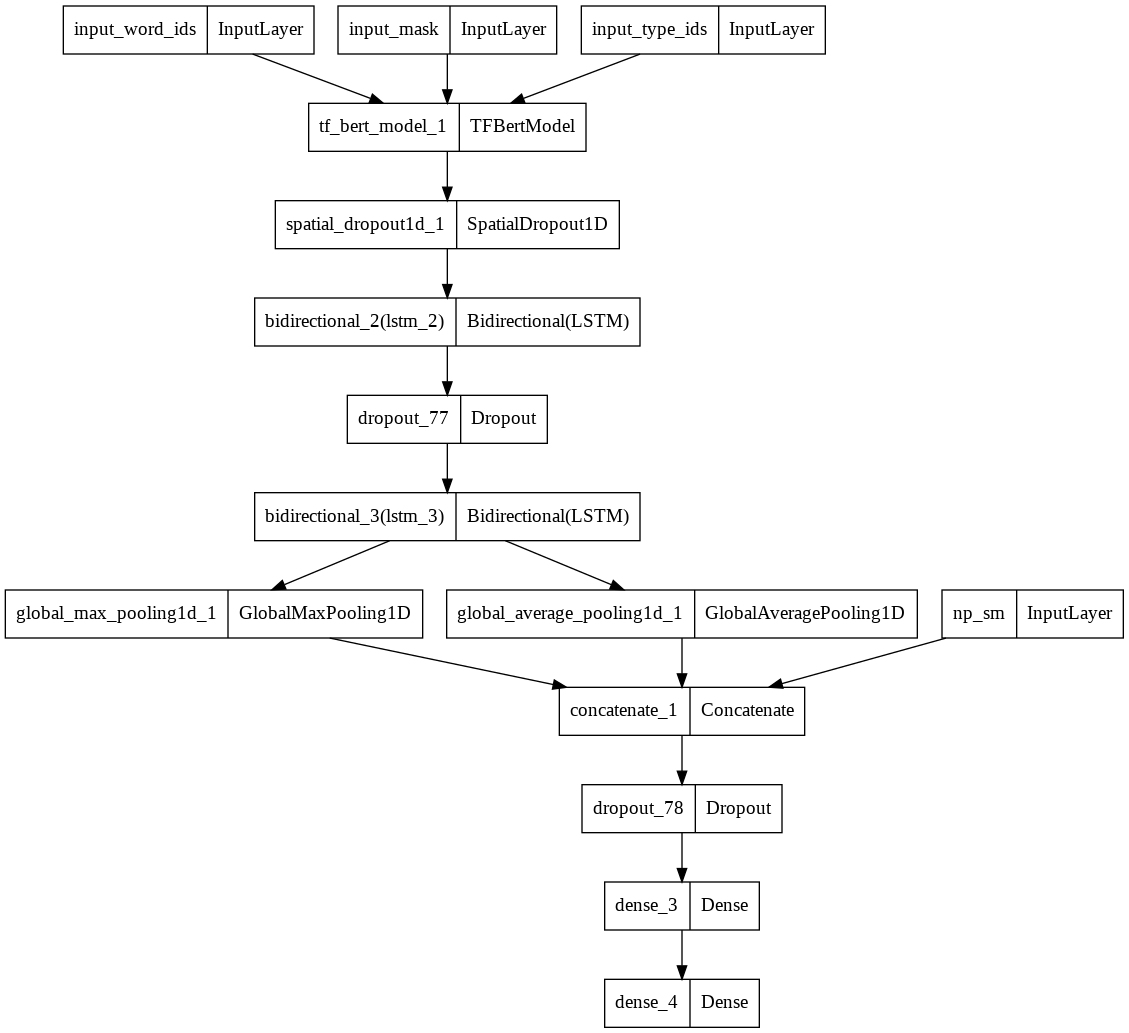

In [28]:
model = build_model5()
model.summary()
tf.keras.utils.plot_model(model)

In [20]:
from sklearn.metrics import classification_report

In [41]:
print('Training...')
history = model.fit(X_train,
                    y_train,
                    epochs=3,
                    batch_size=16,
                    verbose=1,
                    validation_data=(X_test, y_test))

Training...
Epoch 1/3
57/57 [==============================] - 31s 542ms/step - loss: 0.0753 - accuracy: 0.9878 - val_loss: 0.6772 - val_accuracy: 0.7900
Epoch 2/3
57/57 [==============================] - 31s 552ms/step - loss: 0.0684 - accuracy: 0.9878 - val_loss: 0.6897 - val_accuracy: 0.7900
Epoch 3/3
57/57 [==============================] - 32s 561ms/step - loss: 0.0692 - accuracy: 0.9878 - val_loss: 0.7544 - val_accuracy: 0.7900


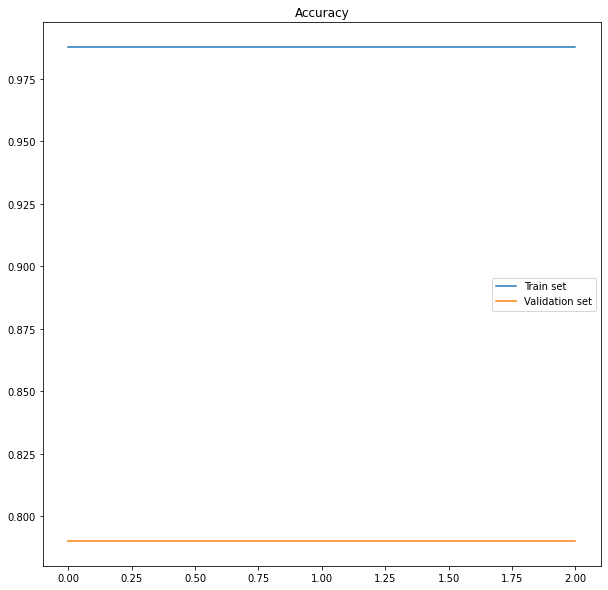

In [42]:
# This plot will look much better if we train models with more epochs, but anyway here is
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()


In [43]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 79.00%


In [44]:
y_pred = [int(np.round(i,0)) for i in model.predict(X_test)]

4/4 [==============================] - 1s 250ms/step


In [45]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.74      0.80        57
           1       0.71      0.86      0.78        43

    accuracy                           0.79       100
   macro avg       0.79      0.80      0.79       100
weighted avg       0.80      0.79      0.79       100



In [46]:
from sklearn.metrics import confusion_matrix
con_mat_df = confusion_matrix(y_test, y_pred)
con_mat_df = con_mat_df.astype('float') / con_mat_df.sum(axis=1)[:, np.newaxis]

[[0.73684211 0.26315789]
 [0.13953488 0.86046512]]


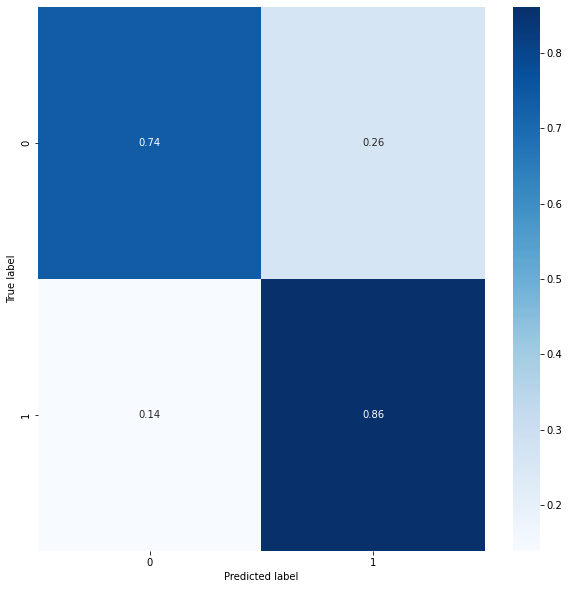

In [47]:
import seaborn as sns
figure = plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
print(con_mat_df)